In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
from matplotlib import pyplot as plt
from mixture_of_gaussians import random_isotropic_mog
from torch.utils.data import TensorDataset
import torch

# sns.set_theme(style="ticks")
device = 'cpu'

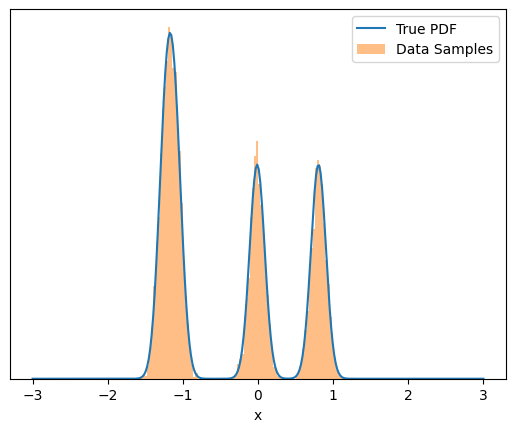

In [86]:
gen = torch.Generator()
gen.manual_seed(0)

mog = random_isotropic_mog(num_modes=4, dim=1, generator=gen, scale_lo=0.01, scale_hi=0.01)

xs = torch.linspace(-3, 3, 300).unsqueeze(-1)
pdf = mog.log_prob(xs).exp()

data_samples = mog.sample((8000,))
dataset = TensorDataset(data_samples)

plt.plot(xs, pdf, label="True PDF")
plt.hist(data_samples, bins=100, density=True, label="Data Samples", alpha=0.5)
plt.legend()
plt.xlabel("x")
plt.yticks([])
plt.show()

tensor(4.0358e-05)


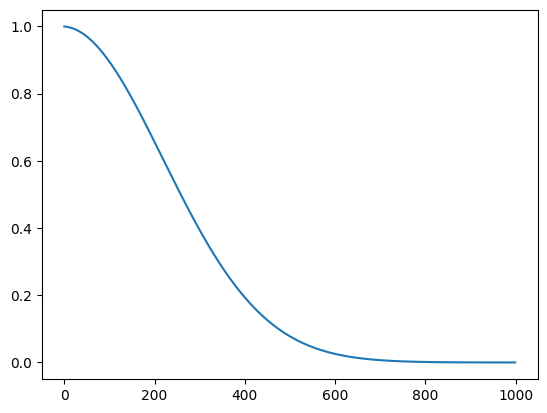

In [141]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0001,
    beta_end=0.02,
    clip_sample=False,
)

plt.plot(scheduler.alphas_cumprod)
print(scheduler.alphas_cumprod[-1])

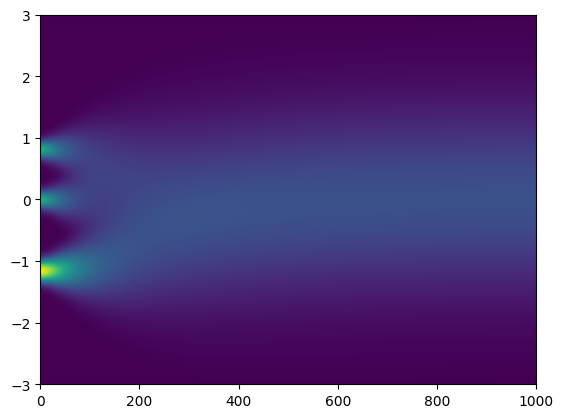

In [142]:
from mixture_of_gaussians import diffuse_mog


# Evaluate the MoG PDF at all noise levels
bound = 3
xs = torch.linspace(-bound, bound, 300).unsqueeze(-1)
pdfs = []
for t in reversed(scheduler.timesteps):
    diffused = diffuse_mog(mog, scheduler.alphas_cumprod, t)
    t_pdf = diffused.log_prob(xs).exp()
    pdfs.append(t_pdf)
pdfs = torch.stack(pdfs).T

plt.imshow(
    pdfs,
    extent=[0, len(scheduler.alphas), -bound, bound],
    origin='lower',
    aspect="auto",
    cmap="viridis",
)

In [143]:
from diffusers import DDIMScheduler
from model import LowDimensionalDiffusionModel

model = LowDimensionalDiffusionModel(in_features=1).to(device)

B = 10
d = 1
x = torch.randn(B, d).to(device)
t = torch.randn(B).to(device)
model(x, t).shape

torch.Size([10, 1])

In [144]:
from ddpm import train_diffusion_model

model = LowDimensionalDiffusionModel(in_features=1).to(device)

class TrainingConfig:
    num_epochs = 50
    train_batch_size = 32
    learning_rate = 1e-3

train_cfg = TrainingConfig()

losses = train_diffusion_model(model, dataset, scheduler, train_cfg, device)
# plt.plot(losses)

Epoch 49 | Loss: 0.1872: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


sampling:   0%|          | 0/100 [00:00<?, ?it/s]

sampling: 100%|██████████| 100/100 [00:01<00:00, 88.34it/s]


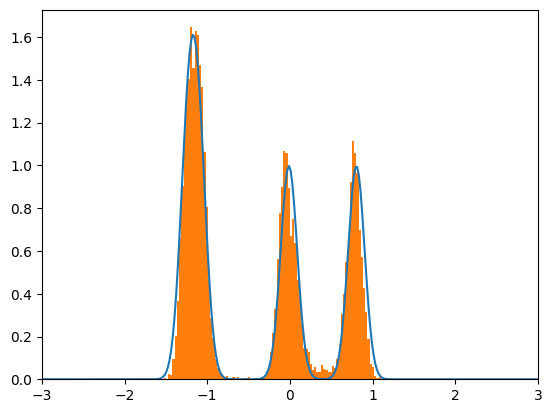

In [93]:
from ddpm import sample_diffusion_model

generated_samples = sample_diffusion_model(
    model, scheduler, (1,), n_samples=8000, n_inference_steps=100
)

plt.figure()
plt.plot(xs, pdf)
plt.hist(generated_samples, bins=100, density=True)
plt.xlim(-3, 3)
plt.show()

In [121]:
from diffusers import (
    EulerDiscreteScheduler,
    PNDMScheduler,
    FlowMatchEulerDiscreteScheduler,
)

inf_scheduler = PNDMScheduler.from_config(scheduler.config)
inf_scheduler = DDPMScheduler.from_config(scheduler.config)
inf_scheduler = FlowMatchEulerDiscreteScheduler.from_config(scheduler.config)
inf_scheduler = EulerDiscreteScheduler.from_config(scheduler.config)
inf_scheduler = DDIMScheduler.from_config(scheduler.config)

The config attributes {'beta_start': 0.0001, 'beta_end': 0.02, 'beta_schedule': 'linear', 'clip_sample': False} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


sampling:   0%|          | 0/10 [00:00<?, ?it/s]

sampling: 100%|██████████| 10/10 [00:00<00:00, 628.77it/s]


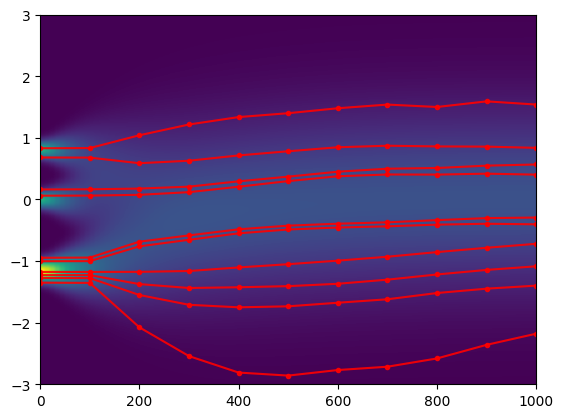

In [122]:
from torch import Generator


gen = Generator()
gen.manual_seed(0)

trajectory = sample_diffusion_model(
    model,
    inf_scheduler,
    (1,),
    n_samples=10,
    n_inference_steps=10,
    output_trajectory=True,
    generator=gen,
)

# plt.hist2d(sample_times.flatten(), samples_flat.flatten(), bins=(50, 50), density=True)
# plt.xlabel("Time")
# plt.ylabel("x")

plt.imshow(
    pdfs,
    extent=[0, len(scheduler.alphas), -bound, bound],
    origin='lower',
    aspect="auto",
    cmap="viridis",
)

plt.plot(
    trajectory.noise_levels,
    trajectory.samples[:, :, 0],
    color="red",
    marker=".",
    alpha=0.9,
)
plt.show()